In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold
from warnings import filterwarnings
filterwarnings('ignore')

import data_load_and_preprocess as dlp

FILE_PATH = r"C:\Users\tempuser\OneDrive - postech.ac.kr\2025\7. KAMP 경진대회\2025_KAMP_anomaly_detection\data\2. 소성가공 품질보증 AI 데이터셋.csv"

DROP_COLS = ['date', 'EX1.MELT_P_PV', 'EX1.MD_PV', 'EX1.MD_TQ']
TARGET = "passorfail"
ALPHA = 0.1


In [ ]:
# 1. Load and Preprocess

df = dlp.load_data(FILE_PATH)
df2 = dlp.basic_preprocess(df)
df3 = dlp.select_features_ttest(df2)

In [3]:
df3

,EX5.MELT_TEMP,EX4.MELT_TEMP,EX3.MELT_TEMP,EX2.MELT_TEMP,EX1.Z1_PV,EX1.Z2_PV,EX1.Z4_PV,EX1.A1_PV,EX1.A2_PV,EX1.H2_PV,EX1.H3_PV,EX1.H4_PV,EX1.H2O_PV,passorfail
0,297.0,222.0,251.0,267.0,209.0,219.0,239.0,240.0,239.0,240.0,240.0,40.0,41.0,0.0
1,297.0,222.0,251.0,268.0,210.0,219.0,239.0,240.0,239.0,240.0,240.0,40.0,41.0,0.0
2,297.0,222.0,251.0,267.0,210.0,219.0,239.0,240.0,239.0,240.0,240.0,40.0,41.0,0.0
3,297.0,222.0,251.0,267.0,210.0,219.0,240.0,240.0,239.0,240.0,240.0,40.0,41.0,0.0
4,297.0,222.0,251.0,267.0,210.0,219.0,239.0,240.0,239.0,240.0,240.0,40.0,41.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17259,296.0,222.0,252.0,267.0,211.0,219.0,240.0,240.0,240.0,239.0,240.0,40.0,42.0,0.0
17260,296.0,222.0,252.0,267.0,211.0,219.0,240.0,240.0,240.0,240.0,240.0,40.0,42.0,0.0
17261,296.0,222.0,252.0,267.0,212.0,219.0,240.0,240.0,240.0,239.0,240.0,40.0,42.0,0.0
17262,296.0,222.0,252.0,267.0,212.0,219.0,240.0,239.0,240.0,239.0,240.0,40.0,42.0,0.0


In [ ]:
# 2-1. Prepare Dataset

# train, test 데이터 준비
data = df3.loc[:,list(df3.columns)[:-1]]
target = df3.loc[:,list(df3.columns)[-1]].astype(int)

# 학습용 데이터, 테스트 데이터의 비율은 8:2로 진행
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=42)
y_train, y_test = np.array(y_train), np.array(y_test)

print('Train :', X_train.shape, 'Test :', X_test.shape)
print('Train :', y_train.shape, 'Test :', y_test.shape)

Train : (13811, 13) Test : (3453, 13)
Train : (13811,) Test : (3453,)


In [ ]:
# 2-2. Set Scaler

# 스케일러 적용
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)

# 훈련 데이터에 스케일러 적용
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# 3. Train Models

# 3-1. Decision Tree

kfold = KFold(n_splits=3, shuffle=True)
dt_kf_acc = []
dt = DecisionTreeClassifier(random_state=42)

n_iter = 0
for train_idx, valid_idx in kfold.split(X_train):
    X_train_, X_valid_ = X_train[train_idx], X_train[valid_idx]
    y_train_, y_valid_ = y_train[train_idx], y_train[valid_idx]

    # DecisionTreeClassifier 훈련
    dt.fit(X_train_, y_train_)
    dt_pred = dt.predict(X_valid_)
    dt_acc = accuracy_score(dt_pred, y_valid_)
    n_iter += 1
    dt_kf_acc.append([n_iter, dt_acc, dt])
    print(f'KFold {n_iter} 교차검증 정확도 : {dt_acc}, 학습 데이터 크기:{X_train_.shape[0]}, 검증 데이터 크기:{y_train_.shape[0]}')

dt_kf_acc_sort = dt_kf_acc
dt_kf_acc_sort.sort(key=lambda x : x[1], reverse=True)

# KFold 검증 후 가장 정확도가 높은 모델 선택
dt = dt_kf_acc_sort[0][2]
print(f'교차검증 중 가장 높은 정확도 : KFold {dt_kf_acc_sort[0][0]}, {dt_kf_acc_sort[0][1]}')

KFold 1 교차검증 정확도 : 0.9976107732406603, 학습 데이터 크기:9207, 검증 데이터 크기:9207
KFold 2 교차검증 정확도 : 0.9995655951346655, 학습 데이터 크기:9207, 검증 데이터 크기:9207
KFold 3 교차검증 정확도 : 0.9958722572235499, 학습 데이터 크기:9208, 검증 데이터 크기:9208
교차검증 중 가장 높은 정확도 : KFold 2, 0.9995655951346655


In [ ]:
# 3-2. Random Forest

kfold = KFold(n_splits=3, shuffle=True)
rf_kf_acc = []
rf = RandomForestClassifier(random_state=42)

n_iter = 0
for train_idx, valid_idx in kfold.split(X_train):
    X_train_, X_valid_ = X_train[train_idx], X_train[valid_idx]
    y_train_, y_valid_ = y_train[train_idx], y_train[valid_idx]

    # RandomForestClassifier 훈련
    rf.fit(X_train_, y_train_)
    rf_pred = rf.predict(X_valid_)
    rf_acc = accuracy_score(rf_pred, y_valid_)
    n_iter += 1
    rf_kf_acc.append([n_iter, rf_acc, rf])
    print(f'KFold {n_iter} 교차검증 정확도 : {rf_acc}, 학습 데이터 크기:{X_train_.shape[0]}, 검증 데이터 크기:{y_train_.shape[0]}')

rf_kf_acc_sort = rf_kf_acc
rf_kf_acc_sort.sort(key=lambda x : x[1], reverse=True)

# KFold 검증 후 가장 정확도가 높은 모델 선택
rf = rf_kf_acc_sort[0][2]
print(f'교차검증 중 가장 높은 정확도 : KFold {rf_kf_acc_sort[0][0]}, {rf_kf_acc_sort[0][1]}')

KFold 1 교차검증 정확도 : 0.9989139878366637, 학습 데이터 크기:9207, 검증 데이터 크기:9207
KFold 2 교차검증 정확도 : 0.998262380538662, 학습 데이터 크기:9207, 검증 데이터 크기:9207
KFold 3 교차검증 정확도 : 0.997393004562242, 학습 데이터 크기:9208, 검증 데이터 크기:9208
교차검증 중 가장 높은 정확도 : KFold 1, 0.9989139878366637


In [ ]:
# 3-3. AdaBoost

kfold = KFold(n_splits=3, shuffle=True)
ada_kf_acc = []
ada = AdaBoostClassifier(random_state=42)

n_iter = 0
for train_idx, valid_idx in kfold.split(X_train):
    X_train_, X_valid_ = X_train[train_idx], X_train[valid_idx]
    y_train_, y_valid_ = y_train[train_idx], y_train[valid_idx]

    # AdaBoostClassifier 훈련
    ada.fit(X_train_, y_train_)
    ada_pred = dt.predict(X_valid_)
    ada_acc = accuracy_score(ada_pred, y_valid_)
    n_iter += 1
    print(f'KFold {n_iter} 교차검증 정확도 : {ada_acc}, 학습 데이터 크기:{X_train_.shape[0]}, 검증 데이터 크기:{y_train_.shape[0]}')

    ada_kf_acc.append([n_iter, ada_acc, ada])

ada_kf_acc_sort = ada_kf_acc
ada_kf_acc_sort.sort(key=lambda x : x[1], reverse=True)

# KFold 검증 후 가장 정확도가 높은 모델 선택
ada = ada_kf_acc_sort[0][2]
print(f'교차검증 중 가장 높은 정확도 : KFold {ada_kf_acc_sort[0][0]}, {ada_kf_acc_sort[0][1]}')

KFold 1 교차검증 정확도 : 0.9986967854039965, 학습 데이터 크기:9207, 검증 데이터 크기:9207
KFold 2 교차검증 정확도 : 0.9993483927019983, 학습 데이터 크기:9207, 검증 데이터 크기:9207
KFold 3 교차검증 정확도 : 0.9986965022811211, 학습 데이터 크기:9208, 검증 데이터 크기:9208
교차검증 중 가장 높은 정확도 : KFold 2, 0.9993483927019983


In [10]:
# 모든 Fold 별 결과 확인
total_fold_df = pd.DataFrame({
    'Decision Tree':[ada_kf_acc[0][1], ada_kf_acc[1][1], ada_kf_acc[2][1]],
    'Random Forest':[rf_kf_acc[0][1], rf_kf_acc[1][1], rf_kf_acc[2][1]],
    'Adaboost':[ada_kf_acc[0][1], ada_kf_acc[1][1], ada_kf_acc[2][1]]},
    index=['Fold1', 'Fold2', 'Fold3'])
total_fold_df

,Decision Tree,Random Forest,Adaboost
Fold1,0.999348,0.998914,0.999348
Fold2,0.998697,0.998262,0.998697
Fold3,0.998697,0.997393,0.998697


DecisionTreeClassifier()
precision: 1.0 recall: 0.9545454545454546
F1-Score: 0.9767441860465116 Accuracy: 0.9997103967564437


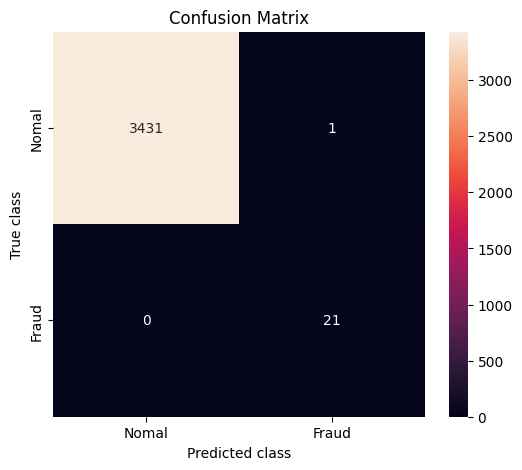

In [13]:
# 4. Test
# 4-1. Decision Tree

# 테스트셋으로 모델 테스트
dt_pred = dt.predict(X_test)
dt_pred = np.choose(dt_pred, [0, 1]).astype(float)
result = {}

# 테스트 정확도 출력
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_acc = accuracy_score(dt_pred, y_test)
dt_cm = confusion_matrix(dt_pred, y_test)
result['DecisionTree'] = {'precision':dt_precision, 'recall':dt_recall, 'f1-score':dt_f1, 'accuracy':dt_acc}
print(f'{dt}\nprecision: {dt_precision} recall: {dt_recall}\nF1-Score: {dt_f1} Accuracy: {dt_acc}')

# Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(dt_cm, xticklabels=['Nomal', 'Fraud'], yticklabels=['Nomal', 'Fraud'], annot=True, fmt="d");
plt.title("Confusion Matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

RandomForestClassifier(random_state=42)
precision: 1.0 recall: 0.9090909090909091
F1-Score: 0.9523809523809523 Accuracy: 0.9994207935128874


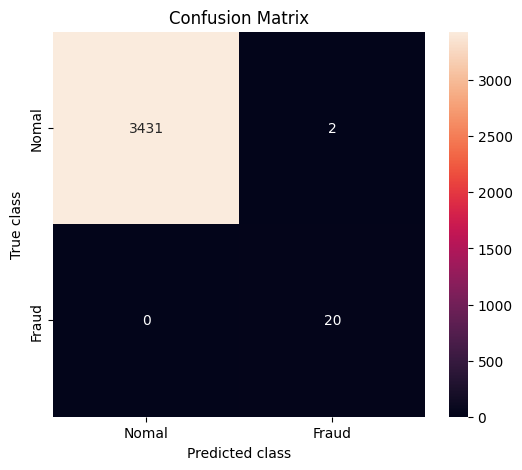

In [14]:
# 4-2. Random Forest

# 훈련된 모델 테스트
rf_pred = rf.predict(X_test)
rf_pred = np.choose(rf_pred, [0, 1]).astype(float)

# 테스트 정확도 출력
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_acc = accuracy_score(rf_pred, y_test)
rf_cm = confusion_matrix(rf_pred, y_test)
result['RandomForest'] = {'precision':rf_precision, 'recall':rf_recall, 'f1-score':rf_f1, 'accuracy':rf_acc}
print(f'{rf}\nprecision: {rf_precision} recall: {rf_recall}\nF1-Score: {rf_f1} Accuracy: {rf_acc}')

# Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(rf_cm, xticklabels=['Nomal', 'Fraud'], yticklabels=['Nomal', 'Fraud'], annot=True, fmt="d");
plt.title("Confusion Matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

AdaBoostClassifier(random_state=42)
precision: 1.0 recall: 0.6818181818181818
F1-Score: 0.8108108108108109 Accuracy: 0.9979727772951057


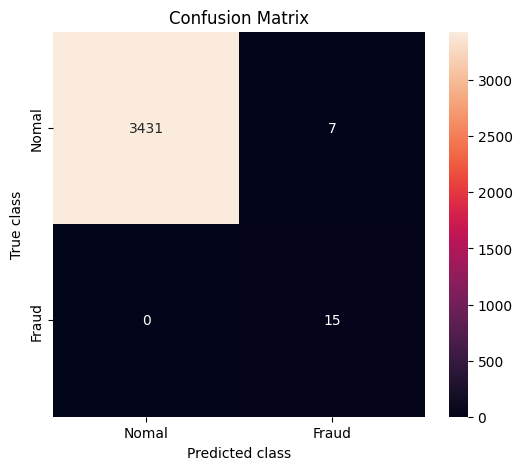

In [15]:
# 4-3. AdaBoost

# 훈련된 모델 테스트
ada_pred = ada.predict(X_test)
ada_pred = np.choose(ada_pred, [0, 1]).astype(float)

# 테스트 정확도 출력
ada_precision = precision_score(y_test, ada_pred)
ada_recall = recall_score(y_test, ada_pred)
ada_f1 = f1_score(y_test, ada_pred)
ada_acc = accuracy_score(ada_pred, y_test)
ada_cm = confusion_matrix(ada_pred, y_test)
result['AdaBoost'] = {'precision':ada_precision, 'recall':ada_recall, 'f1-score':ada_f1, 'accuracy':ada_acc}
print(f'{ada}\nprecision: {ada_precision} recall: {ada_recall}\nF1-Score: {ada_f1} Accuracy: {ada_acc}')

# Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(ada_cm, xticklabels=['Nomal', 'Fraud'], yticklabels=['Nomal', 'Fraud'], annot=True, fmt="d");
plt.title("Confusion Matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [16]:
# 모델별 학습 결과 출력
pd.DataFrame(result).T

,precision,recall,f1-score,accuracy
DecisionTree,1.0,0.954545,0.976744,0.999710
RandomForest,1.0,0.909091,0.952381,0.999421
AdaBoost,1.0,0.681818,0.810811,0.997973


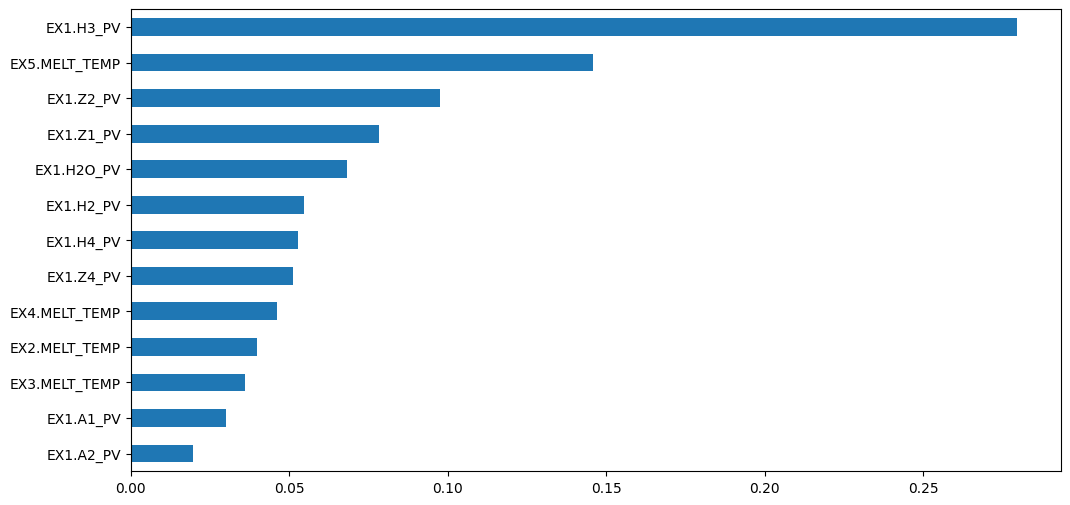

In [17]:
# RandomForest Feature importances 시각화
rf_importance = rf.feature_importances_
rf_importances = pd.Series(rf_importance, data.columns)
plt.figure(figsize=(12, 6))
rf_importances.sort_values().plot.barh();